# Graph ST

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 11.01.2023
- **Date of Last Modification:** 11.01.2023

- The workflow of this notebook follows the tutorial from https://deepst-tutorials.readthedocs.io/en/latest/Tutorial%201_10X%20Visium.html.
- Graph ST requires raw counts as input (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import os
from datetime import datetime

import multiprocessing as mp
import pandas as pd
import scanpy as sc
import torch
from GraphST import GraphST
from sklearn import metrics

### 1.2 Define Parameters

In [2]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
latent_key = "graphst_latent"
leiden_resolution = 0.3
n_clusters = 7
random_seed = 0

### 1.3 Run Notebook Setup

In [3]:
sc.set_figure_params(figsize=(6, 6))

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [5]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ["R_HOME"] = "/home/cartalop/anaconda3/envs/graphst/lib/R/bin/R"

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/method_benchmarking/{dataset}/"

In [7]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Data

In [8]:
# Load data
adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
adata.X = adata.layers["counts"].toarray()

## 3. Graph ST Model

In [9]:
# Define model
model = GraphST.GraphST(adata, device=device)

In [10]:
# Train model
adata = model.train()

Begin to train ST data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [11:03<00:00,  1.11s/it]


Optimization finished for ST data!


In [12]:
adata

AnnData object with n_obs × n_vars = 14185 × 351
    obs: 'Area', 'celltype_mapped_refined'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'X_name', 'celltype_mapped_refined_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'
    layers: 'counts'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot:title={'center':'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

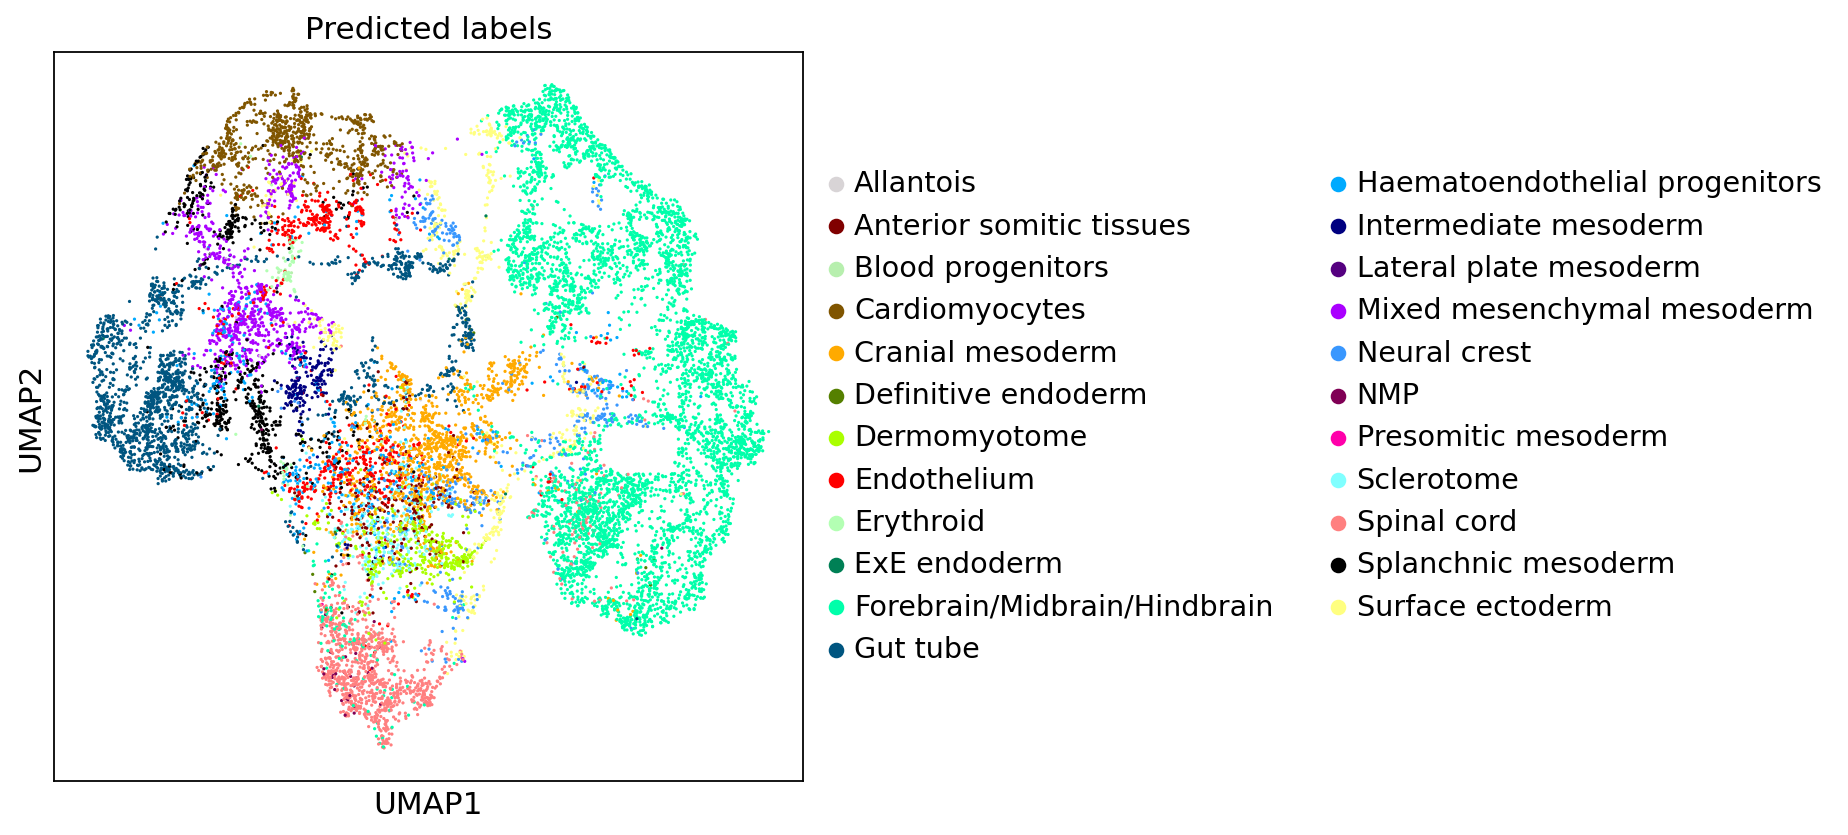

In [13]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep="emb", n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color=cell_type_key, title=['Predicted labels'], show=False)

In [ ]:
adata_original = adata.copy()

for run_number, n_neighbors in enumerate([4, 4, 8, 8, 12, 12, 16, 16, 20, 20]): # 2 runs per n_neighbors for a total of 10 runs
    # Compute spatial neighborhood graph for clustering
    sq.gr.spatial_neighbors(adata,
                            coord_type="generic",
                            spatial_key="spatial")
    
    # Estimate gene interaction network
    glasso(adata, [0.25, 0.5]) # the adjacency matrix of the built graph is added under 'adata.varm["adj"]'
    
    # Compute spatial partitoning with 3 different resolutions to capture different granularities
    # (0,5 x n_cell_categories -> 11, n_cell_categories -> 23, 2 x n_cell_categories -> 46)
    sc.tl.leiden(adata,
                 resolution=.075, # 11 clusters
                 random_state=random_seed,
                 key_added="leiden_11",
                 adjacency=adata.obsp["spatial_connectivities"]) # the partitioning is added under 'adata.obs["leiden_0.05"]'
    sc.tl.leiden(adata,
                 resolution=.275, # 23 clusters
                 random_state=random_seed,
                 key_added="leiden_23",
                 adjacency=adata.obsp["spatial_connectivities"]) # the partitioning is added under 'adata.obs["leiden_0.1"]'
    sc.tl.leiden(adata,
                 resolution=.8455, # 46 clusters
                 random_state=random_seed,
                 key_added="leiden_46",
                 adjacency=adata.obsp["spatial_connectivities"]) # the partitioning is added under 'adata.obs["leiden_0.5"]'
    sc.pl.spatial(adata,
                  color=["leiden_11", "leiden_23", "leiden_46"],
                  frameon=False,
                  ncols=3,
                  spot_size=.1,
                  title=["leiden_11", "leiden_23", "leiden_46"],
                  legend_loc=None)
    
    # Define model object
    sg_obj = sca.models.sagenet(device=device)
    
    sg_obj.train(adata,
                 comm_columns=["leiden_11", "leiden_23", "leiden_46"],
                 tag="embryo2",
                 epochs=15,
                 verbose = False,
                 importance=True)
    
    sg_obj.load_query_data(adata)
    
    # Use SageNet cell-cell-distances for UMAP generation
    sc.pp.neighbors(adata, use_rep="dist_map", n_neighbors=n_neighbors)
    sc.tl.umap(adata, min_dist=0.3)
    fig = sc.pl.umap(adata,
                     color=[cell_type_key],
                     title="Latent Space with Cell Types: SageNet",
                     return_fig=True)
    fig.savefig(f"{figure_folder_path}/latent_sagenet_cell_types_run_{run_number+1}_{current_timestamp}.png",
                bbox_inches="tight")
    
    # Compute latent Leiden clustering
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolution,
                 random_state=random_seed,
                 key_added=f"latent_sagenet_leiden_{str(leiden_resolution)}")
    
    # Create subplot of latent Leiden cluster annotations in physical and latent space
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
    title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: SageNet")
    sc.pl.umap(adata=adata,
               color=[f"latent_sagenet_leiden_{str(leiden_resolution)}"],
               title=f"Latent Space with Leiden Clusters",
               ax=axs[0],
               show=False)
    sc.pl.spatial(adata=adata,
                  color=[f"latent_sagenet_leiden_{str(leiden_resolution)}"],
                  spot_size=0.03,
                  title=f"Physical Space with Leiden Clusters",
                  ax=axs[1],
                  show=False)

    # Create and position shared legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.75))
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()

    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    fig.savefig(f"{figure_folder_path}/latent_physical_comparison_sagenet_leiden_run_{run_number+1}_{current_timestamp}.png",
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
    plt.show()
    
    adata_original.obsm[latent_key + f"_run{run_number+1}"] = adata.obsm["dist_map"]
    
# Label all 'gene programs' as active gene programs for subsequent benchmarking
adata_original.uns["sagenet_active_gp_names"] = np.array([f"latent_{i}" for i in range(adata_original.obsm["sagenet_latent_run1"].shape[1])])
    
# Store data to disk
adata_original.write(f"{data_folder_path}/{dataset}_sagenet.h5ad")